In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import importlib

# import from custom package
from auxFuns.EDA import *

In [4]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA )

<module 'auxFuns.EDA' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\EDA.py'>

# 1. Loading the data and summary function

In [6]:
datasets_path = os.getcwd() + '/datasets/raw'

In [7]:
rsv_predictors_phase1_df = pd.read_csv(datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)

In [8]:
# Add also the opportunity to load the preocessed files already here:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)


rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

In [73]:
summary_function_rsv(rsv_predictors_phase1_df)

                CCI          sine        cosine    n_symptoms  n_encounters  \
count  86659.000000  86659.000000  8.665900e+04  86659.000000  86659.000000   
mean       2.360297      0.305377  3.863281e-01      2.145963      4.697642   
std        2.432005      0.639752  5.901029e-01      1.702432      6.967793   
min        0.000000     -1.000000 -1.000000e+00      0.000000      1.000000   
25%        0.000000     -0.239316 -1.608123e-16      1.000000      1.000000   
50%        2.000000      0.464723  5.680647e-01      2.000000      2.000000   
75%        4.000000      0.885456  8.854560e-01      3.000000      5.000000   
max       14.000000      1.000000  1.000000e+00     13.000000     79.000000   

       prev_positive_rsv  tendency_to_positivity  previous_test_daydiff  \
count       86659.000000            86659.000000           8.665900e+04   
mean            0.061159                0.030626           3.788330e+05   
std             0.394196                0.127717           4.77

# 2. Plots of positivity and evaluation of correlations

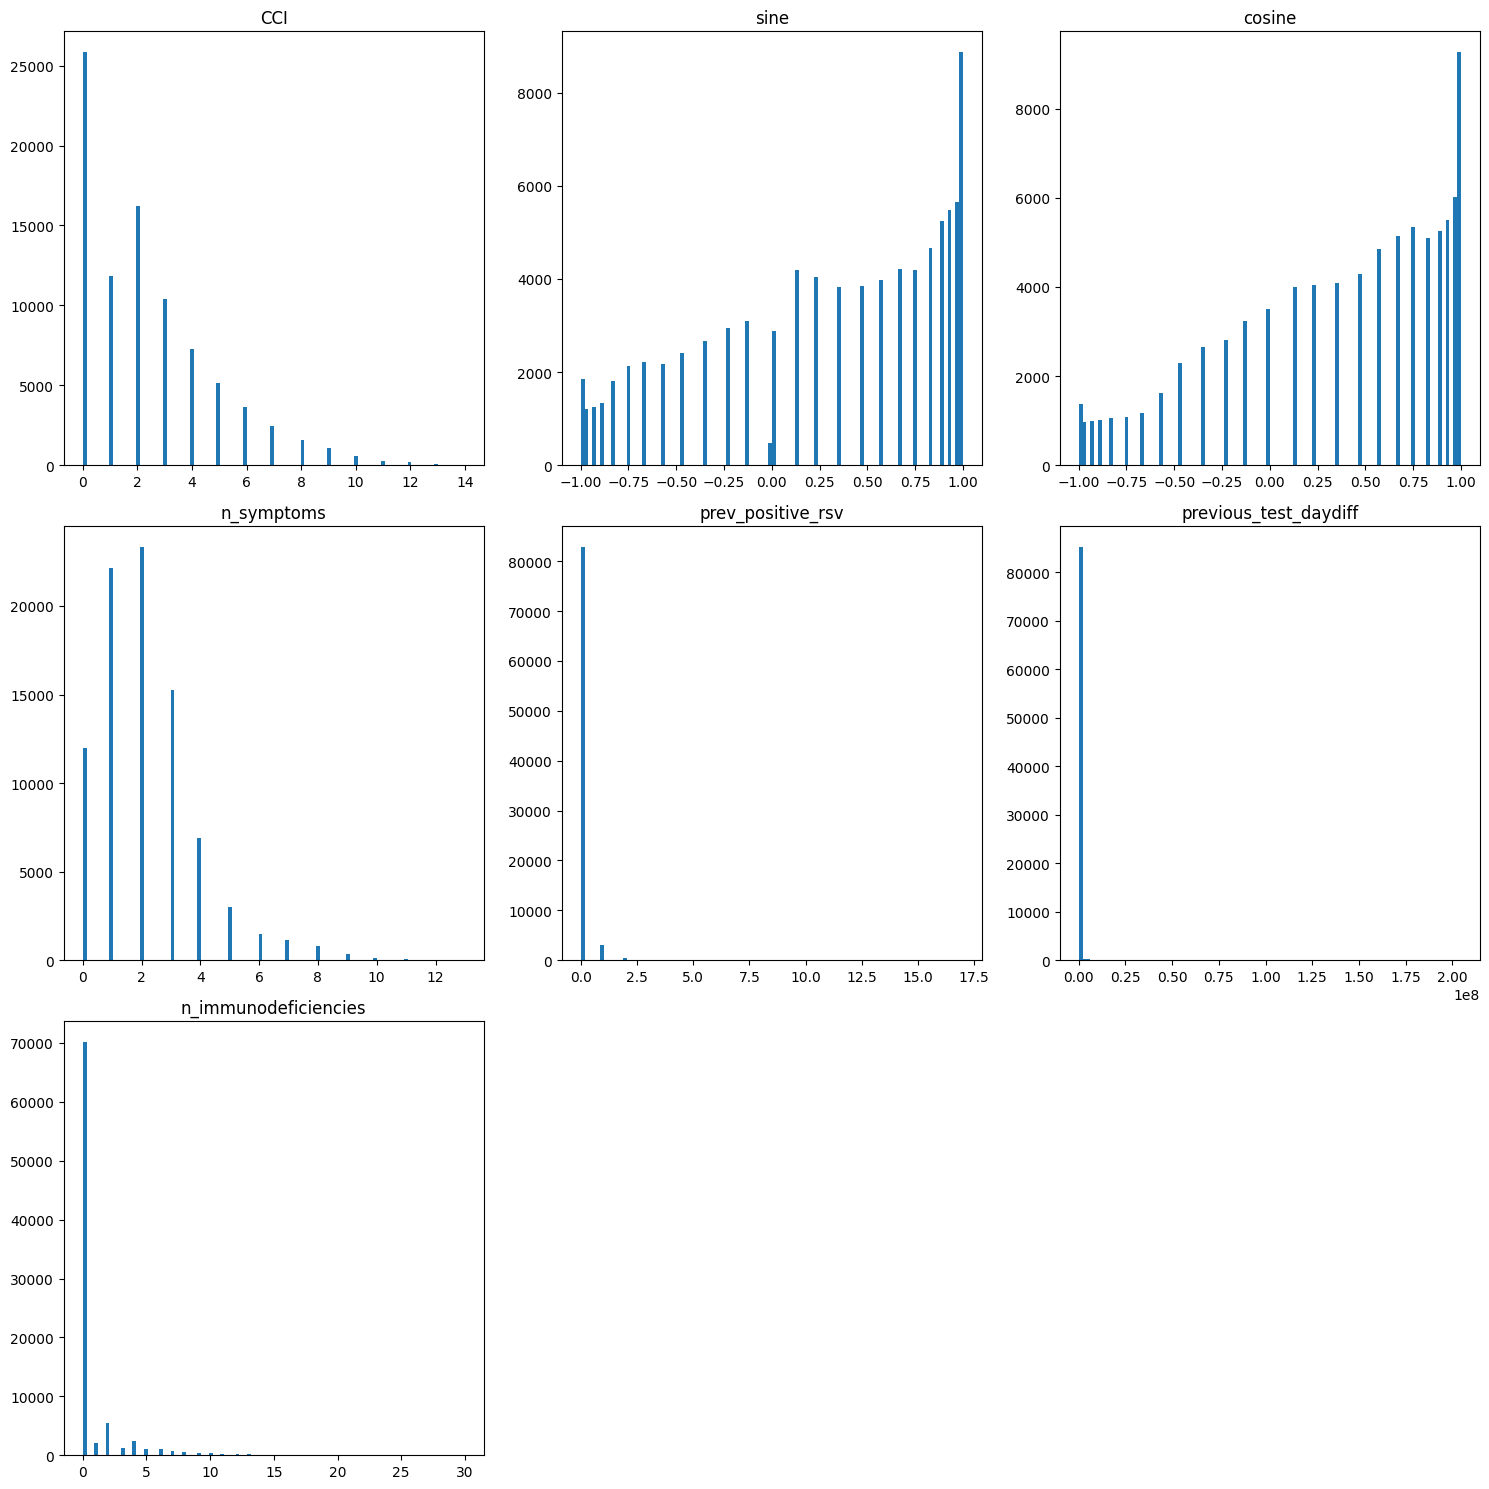

In [28]:
# Start by evaluating the distribution of specific columns
columns_to_inspect = ['CCI', 'sine','cosine', 'n_symptoms', 
                      'prev_positive_rsv', 'previous_test_daydiff', 'n_immunodeficiencies']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten() # axes are flattened to be able to iterate over them

for i, col in enumerate(columns_to_inspect):
    # if col == "sine" or col =="cosine":
    #     data = np.exp(rsv_predictors_phase1_df[col])
    # else:
    #     data = np.log(rsv_predictors_phase1_df[col] + 1)

    data = rsv_predictors_phase1_df[col]
    axs[i].hist(data, bins=100)  
    axs[i].set_title(col)

# Sanity check: eliminate all extra axes
for j in range(i+1, 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### 2.1 Granular method :
- First, differentiate patients with no past RSV test records
- Second, differentiate between tests in different seasons of the year

- Differentiating patients with no past RSV test records

In [11]:
# Have a closer look at previous_test_day_diff

# Let's take them from the dedup file (see point 3) as this will likely bring more relevant results
df = rsv_predictors_phase1_daysDedup_df

# count_records_per_patient = df.groupby('patient_id').size()
# locator_one_record_patients = df.groupby('patient_id').size() == 1
# one_record_patients_v0 = count_records_per_patient[locator_one_record_patients].index

one_record_patients = df.groupby('patient_id').size().loc[lambda x: x == 1].index

rsv_one_record = df.loc[
    df['patient_id'].isin(one_record_patients)]

rsv_multiple_records = df.loc[
    ~df['patient_id'].isin(one_record_patients)]

rsv_one_record = rsv_one_record.copy()
rsv_multiple_records = rsv_multiple_records.copy()
rsv_one_record.loc[:,'multiple_tests'] = False
rsv_multiple_records.loc[:,'multiple_tests'] = True

In [12]:
# See if the difference in positivity proportion is relevant
pos_one_record = rsv_one_record['RSV_test_result'].value_counts()[1]
p_one_record = pos_one_record / rsv_one_record.shape[0] # 3.29%

pos_multiple_records = rsv_multiple_records['RSV_test_result'].value_counts()[1]
p_multiple_records = pos_multiple_records / rsv_multiple_records.shape[0] # 2.95 %

p_one_record, p_multiple_records

print(f'Positivity percentage in patients with only one record: {p_one_record*100}')
print(f'Positivity percentage in patients with multiple records: {p_multiple_records*100}')

# Making a comprobation of the differences between positiviy rates in the two populations
z, p = sm.stats.proportions_ztest([pos_one_record, pos_multiple_records], [rsv_one_record.shape[0], rsv_multiple_records.shape[0]])
print('z-score:', z)
print('p-value:', p)

Positivity percentage in patients with only one record: 3.2925051035287254
Positivity percentage in patients with multiple records: 2.945835265028589
z-score: 2.87993190702208
p-value: 0.003977610681573247


- Seasonality of the testing

In [13]:
# Have a closer look at the seasonality of testing

# Let's take them from the dedup file (see point 3) as this will likely bring more relevant results
df = rsv_predictors_phase1_daysDedup_df

df['month_of_the_test'] = pd.to_datetime(df['index_date']).dt.month
df['season'] = df['month_of_the_test'].apply(get_season_rsv)

In [14]:
for season in ['winter', 'spring', 'summer', 'autumn']:
    pos_tests = df.loc[df['season'] == season,'RSV_test_result'].value_counts()[1]

    p_positivity = pos_tests / (df.loc[df['season'] == season].shape[0])

    print(f'Season: {season}')
    print(f'Positiviy: {p_positivity * 100}')

Season: winter
Positiviy: 4.414359905208491
Season: spring
Positiviy: 2.291828649709356
Season: summer
Positiviy: 0.7528860632424293
Season: autumn
Positiviy: 1.7827838281366555


- Create new data frame incorportating this information

In [15]:
# Create a dataframe having extra features: flag_previous tests, month_test, season_test

df = rsv_predictors_phase1_daysDedup_df
# 1st, flag to indicate if they had previous tests or not
one_record_patients = df.groupby('patient_id').size().loc[lambda x: x == 1].index

df = df.copy()
df.loc[df['patient_id'].isin(one_record_patients),'multiple_tests'] = False
df.loc[~df['patient_id'].isin(one_record_patients),'multiple_tests'] = True

# 2nd, seasonality
df['month_of_the_test'] = pd.Categorical(pd.to_datetime(df['index_date']).dt.month,
                                         categories = [1,2,3,4,5,6,7,8,9,10,11,12])
df['season'] = pd.Categorical(df['month_of_the_test'].apply(get_season_rsv), 
                              categories=['winter', 'spring', 'summer', 'autumn'])

In [16]:
df.to_csv('rsv_predictors_phase1_daysDedup_seasons_prevTest.csv', index=False)

# 3. Evaluate positivity within a short period of time
- Tests in the same day and same patient
- Tests in the same week (and same patient)

In [9]:
rsv_predictors_phase1_df['index_date'] = pd.to_datetime(rsv_predictors_phase1_df['index_date']).dt.date

In [31]:
# I want to see (same Day)
# a) how many tests are taken at the same day and same patient 
# b) how many have i) positive-positive, ii) negative-negative, iii) negative-positive

# Take only those records having more than one test that day
more_one_rsv_test_df = (
    rsv_predictors_phase1_df.loc[rsv_predictors_phase1_df['n_tests_that_day'] == 2, 
                                 ['patient_id', 'index_date', 'RSV_test_result']]
                                 )

more_one_rsv_test_df.shape # 1202 records, i.e. 601 test records the same day

(more_one_rsv_test_df['RSV_test_result'] == 'Positive').sum() # 601
(more_one_rsv_test_df['RSV_test_result'] == 'Negative').sum() # 601

# It seems that, every time a test is repeated, there exists one negative and positive test

series_grouped = more_one_rsv_test_df.groupby(['patient_id', 'index_date']).apply(aggregate_same_day_test_results)
# This returns a multi-index (patient_id and index_date) pd.Series
# We can reconvert this to a df

df_grouped = series_grouped.reset_index().rename(columns = {0: 'test_combination'})
df_grouped['test_combination'] = pd.Categorical(
    df_grouped['test_combination'], categories = ['NegNeg', 'PosPos', 'PosNeg'])

In [32]:
df_grouped.describe()

,patient_id,index_date,test_combination
count,601,601,601
unique,536,440,1
top,39c750b5343111eeb7ecd9f0ab68ae132df5610a,2018-11-27,PosNeg
freq,12,6,601


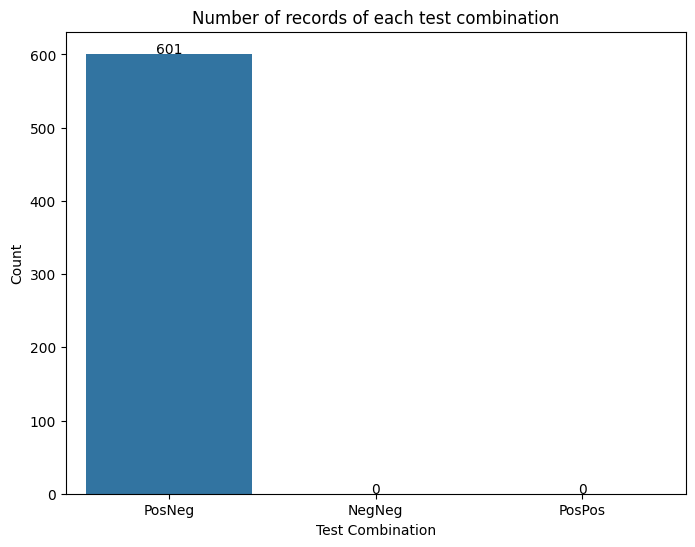

In [33]:
counts = df_grouped['test_combination'].value_counts() # returns a series with index the categories and values the counts per category

counts_df = pd.DataFrame({'test_combination': counts.index, 'count': counts.values})

plt.figure(figsize=(8, 6))
sns.barplot(
    x='test_combination', y='count', data=counts_df, order = ['PosNeg', 'NegNeg', 'PosPos'])
plt.xlabel('Test Combination')
plt.ylabel('Count')
plt.title('Number of records of each test combination')

# Add labels
for i, row in counts_df.iterrows():
    plt.text(i, row['count'], row['count'], color='black', ha="center")
    
plt.show()

Every time a patient is tested twice in a day, they result in a positive-negative combination.

This happens in 601 (out of 2654) positive tests, roughly a 22% of total Positive test. As it is a relevant percentage, a further pre processing step is proposed: cleaning these duplicates

In [34]:
# Test deduplication clean up

one_test_days_df = rsv_predictors_phase1_df.loc[
    rsv_predictors_phase1_df['n_tests_that_day'] == 1]

two_test_days_positive_only_df = rsv_predictors_phase1_df.loc[
    (rsv_predictors_phase1_df['n_tests_that_day'] == 2) & (rsv_predictors_phase1_df['RSV_test_result'] == 'Positive')
]

rsv_predictors_phase1_daysDedup_df = pd.concat([one_test_days_df, two_test_days_positive_only_df], axis = 0)


In [35]:
rsv_predictors_phase1_daysDedup_df['RSV_test_result'].value_counts()

RSV_test_result
Negative    83404
Positive     2654
Name: count, dtype: int64

# 4. Creation of two new features: BPA and BPAI

Literature review indicates how the presence of Bronchitis, Pneumonia and Acute Respiratory Infections are a strong predictor for RSV positivity. We add these features to the current model, together with Influenza, as it has been identified as relevant in previous model selection steps.

In [64]:
# Creation of two new predictors

aux_df = rsv_predictors_df_v2.copy()

aux_df['Bronchitis'] = aux_df['Bronchitis'].astype('int')
aux_df['Pneumonia'] = aux_df['Pneumonia'].astype('int')
aux_df['Influenza'] = aux_df['Influenza'].astype('int')
aux_df['Acute_upper_respiratory_infection'] = aux_df['Acute_upper_respiratory_infection'].astype('int')

aux_df['BPAI'] = aux_df['Bronchitis'] + aux_df['Pneumonia'] + aux_df['Influenza'] + aux_df['Acute_upper_respiratory_infection']
aux_df['BPA'] = aux_df['Bronchitis'] + aux_df['Pneumonia'] + aux_df['Acute_upper_respiratory_infection'] 

aux_df.shape, rsv_predictors_df_v2.shape

((86058, 64), (86058, 62))

# 5. Clustering of the records

Goal: evaluate if there exists clear clusters of RSV tests and evaluate clustering as a potential good step in pre processing

Three approaches to try clustering:

1. FAMD 
2. Distance-based methods (e.g. Gower)
3. Compression of the data (based on language data techniques)

In [88]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince

In [74]:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [75]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
# selected_features = ['sex', 'marital_status', 'race', 'patient_regional_location', 'age_group',
#                      'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
#                      'COPD','AIDS','Asthma_chronic','CCI',
#                      'sine','cosine','calendar_year', 
#                      'healthcare_seeking', 'influenza_vaccine',
#                      'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
#                      'tumor_indicator','tumor_last_year']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [78]:
df1 = rsv_predictors_df_v2[selected_features_v3]
df1.shape

(86058, 27)

### 5.1. FAMD

In [83]:
sample_size = 10000
sample_df = df1.sample(n = sample_size, random_state=42)

In [129]:
df = sample_df
famd = prince.FAMD(n_components=3, random_state=42)

# Fit the FAMD model
famd = famd.fit(df)

# transform the data
df_transformed = famd.transform(df)

# Choose the number of clusters (for example 3) and fit kmeans to the FAMD transformed data
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_transformed)

# add the cluster labels to your dataframe
df_transformed['Cluster'] = kmeans.labels_

# Create a 3D scatter plot of the FAMD transformed data before clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_transformed[0], df_transformed[1], df_transformed[2])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('FAMD transformed data before clustering')
plt.show()

# Create a 3D scatter plot of the FAMD transformed data after clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_transformed[0], df_transformed[1], df_transformed[2], c=df_transformed['Cluster'], cmap='viridis')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('FAMD transformed data after clustering')
plt.show()

In [126]:
sample_df['Cluster'] = df_transformed['Cluster']

In [127]:
for cl in sample_df['Cluster'].unique():
    aux_df = sample_df.loc[sample_df['Cluster'] == cl]
    neg = aux_df['RSV_test_result'].value_counts()[0]
    pos = aux_df['RSV_test_result'].value_counts()[1]
    print(pos / neg)

0.020514883346741754
0.03722854188210962
0.015795868772782502
0.031746031746031744
0.005655042412818096
0.03260869565217391
0.028089887640449437
0.06422018348623854
0.029411764705882353
0.0410958904109589


<Axes: xlabel='0', ylabel='1'>

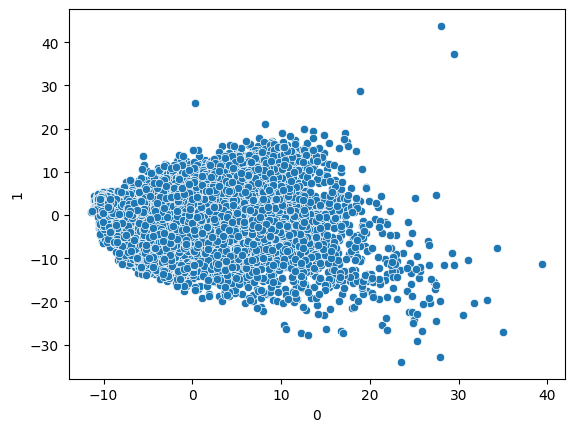

In [87]:
sns.scatterplot(data=df_transformed, x=0, y=1)
